In [2]:
from xml.etree import ElementTree
from pathlib import Path
import pandas as pd
from collections import deque, Counter

In [3]:
def get_inner_names(root):
    column_names = []
    queue = deque([root])
    
    while queue:
        childs, child_names = get_childs(queue.popleft())
        queue.extend(childs)
        column_names.extend(child_names)
    
    return column_names

def get_childs(root):
    names = [child.tag for child in root]
    return list(root), names

def convert_xml_to_df(dataset_path):
    dataset_path = Path(dataset_path)
    dataset = []
    
    for xml_path in dataset_path.rglob("*.xml"):
        xml_tree = ElementTree.parse(xml_path)
        
        root = xml_tree.getroot()
        dataset_elem = {}
        
        column_names = get_inner_names(root)
        cnt = Counter(column_names)
        num_objs = cnt['object']
        
        uniqie_column_names = list(set(column_names))
        obj_names = get_inner_names(root.find("object"))
        
        for name in set(uniqie_column_names)-set(obj_names):
                dataset_elem[name] = list(root.iter(name))[0].text
        
        dataset_elems = [dataset_elem.copy() for i in range(num_objs)]
        for idx, obj in enumerate(root.iter("object")):
            for name in obj_names:
                dataset_elems[idx][name] = list(obj.iter(name))[0].text
                
        dataset.extend(dataset_elems)
        
    dataset = pd.DataFrame(dataset)
    return dataset

In [4]:
data = convert_xml_to_df("../data")
for column_name in ['xmin', 'xmax', 'ymin', 'ymax', 'width', 'depth', 'height', 'segmented', 'truncated', 'difficult']:
    data[column_name] = data[column_name].astype(int)
data.head()

,database,size,depth,folder,path,filename,source,object,height,segmented,width,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax
0,Unknown,\n\t\t,3,images,validation/images/pic(22).jpg,pic(22).jpg,\n\t\t,\n\t\t,198,0,254,fire,Unspecified,0,0,\n\t\t\t,92,18,235,96
1,Unknown,\n\t\t,3,images,validation/images/small(16).jpg,small(16).jpg,\n\t\t,\n\t\t,182,0,277,fire,Unspecified,0,0,\n\t\t\t,151,32,165,61
2,Unknown,\n\t\t,3,images,validation/images/pic(3).jpg,pic(3).jpg,\n\t\t,\n\t\t,168,0,300,fire,Unspecified,0,0,\n\t\t\t,110,82,197,135
3,Unknown,\n\t\t,3,images,validation/images/small(23).jpg,small(23).jpg,\n\t\t,\n\t\t,262,0,192,fire,Unspecified,0,0,\n\t\t\t,72,66,100,125
4,Unknown,\n\t\t,3,images,validation/images/small(29).jpg,small(29).jpg,\n\t\t,\n\t\t,275,0,183,fire,Unspecified,0,0,\n\t\t\t,80,24,106,103


In [130]:
data['database'].unique()

array(['Unknown'], dtype=object)

In [131]:
data['segmented'].unique()

array([0])

In [5]:
data['truncated'].value_counts()

0    691
1     10
Name: truncated, dtype: int64

In [133]:
data['difficult'].unique()

array([0])

In [134]:
data['name'].unique()

array(['fire'], dtype=object)

In [135]:
data['pose'].unique()

array(['Unspecified'], dtype=object)

In [136]:
print(f"Max values w={data['width'].max()}, h={data['height'].max()}, d={data['depth'].max()}")
print(f"Min values w={data['width'].min()}, h={data['height'].min()}, d={data['depth'].min()}")

Max values w=367, h=303, d=3
Min values w=156, h=135, d=3


In [6]:
data['y'] = data.apply(lambda row: row['ymax']-row['ymin'], axis=1)
data['x'] = data.apply(lambda row: row['xmax']-row['xmin'], axis=1)
data['taken_area'] = data.apply(lambda row: (row['x']*row['y'])/(row['width']*row['height']), axis=1)

In [11]:
data['area'] = data.apply(lambda row: row['width']*row['height'], axis=1)
data['aspect_ratio'] = data.apply(lambda row: row['width']/row['height'], axis=1)

In [12]:
data.head()

,database,size,depth,folder,path,filename,source,object,height,segmented,...,bndbox,xmin,ymin,xmax,ymax,y,x,taken_area,area,aspect_ratio
0,Unknown,\n\t\t,3,images,validation/images/pic(22).jpg,pic(22).jpg,\n\t\t,\n\t\t,198,0,...,\n\t\t\t,92,18,235,96,78,143,0.221785,50292,1.282828
1,Unknown,\n\t\t,3,images,validation/images/small(16).jpg,small(16).jpg,\n\t\t,\n\t\t,182,0,...,\n\t\t\t,151,32,165,61,29,14,0.008053,50414,1.521978
2,Unknown,\n\t\t,3,images,validation/images/pic(3).jpg,pic(3).jpg,\n\t\t,\n\t\t,168,0,...,\n\t\t\t,110,82,197,135,53,87,0.091488,50400,1.785714
3,Unknown,\n\t\t,3,images,validation/images/small(23).jpg,small(23).jpg,\n\t\t,\n\t\t,262,0,...,\n\t\t\t,72,66,100,125,59,28,0.032840,50304,0.732824
4,Unknown,\n\t\t,3,images,validation/images/small(29).jpg,small(29).jpg,\n\t\t,\n\t\t,275,0,...,\n\t\t\t,80,24,106,103,79,26,0.040815,50325,0.665455


<AxesSubplot:>

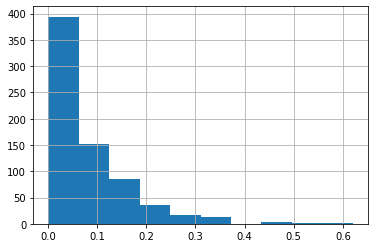

In [13]:
data['taken_area'].hist()

<AxesSubplot:>

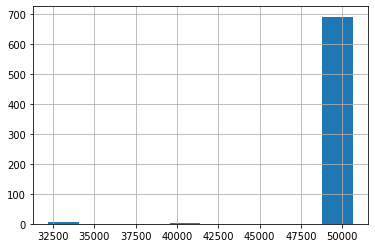

In [14]:
data['area'].hist()

<AxesSubplot:>

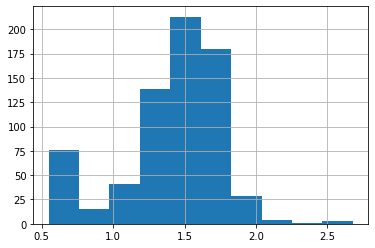

In [15]:
data['aspect_ratio'].hist()